In [1]:
import h5py
import numpy as np
import os
import pandas as pd
import scipy
import subprocess
import time

from os import listdir
from os.path import isfile, join

import bacco
import baccoemu

import matplotlib
from matplotlib import pyplot as plt

2024-01-07 21:16:29.555656: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-07 21:16:29.874190: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-07 21:16:29.874332: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-07 21:16:29.923917: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-07 21:16:30.034578: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-07 21:16:30.036544: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [2]:
matplotlib.rcParams['ytick.labelsize'] = 16
matplotlib.rcParams['xtick.labelsize'] = 16
matplotlib.rcParams['axes.labelsize'] = 18
matplotlib.rcParams['legend.fontsize'] = 14
matplotlib.rcParams['axes.titlesize'] = 20

#matplotlib.rc('text', usetex=True)

## Bacco setup

In [3]:
##### DEFINE QUIJOTE COSMOLOGY ############
# The cosmology is not really needed but
# bacco P(k) corrects some modes according
# to their cosmology, so better have it
# just in case

a_Quijote = 1
Ob = 0.049
Om = 0.3175
hubble = 0.6711
ns = 0.9624
sigma8 = 0.834
cosmopars = dict(
        omega_cdm=Om-Ob,
        omega_baryon=Ob, 
        hubble=hubble, 
        ns=ns, 
        sigma8=sigma8,
        #tau=0.0561,
        A_s=None,
        neutrino_mass=0.,
        w0=-1,
        wa=0,
        tag="cosmo_BOSS"
    )
    
    
cosmo_Quijote = bacco.Cosmology(**cosmopars)
cosmo_Quijote.set_expfactor(a_Quijote)

2024-01-07 21:16:38,952 bacco.cosmo :    initialization took 0.000 secs


In [4]:
ngrid = 256 #1024 #512 #256 #128 #256 #1400
#nmean=0.01 not used
BoxSize=100/hubble
print(BoxSize)

bacco.configuration.update({'pknbody' : {'ngrid'  :  ngrid}})
bacco.configuration.update({'pknbody' : {'log_binning' : True}})
bacco.configuration.update({'pknbody' : {'log_binning_kmax' : 0.99506136}})#
bacco.configuration.update({'pknbody' : {'log_binning_nbins' : 100}})
bacco.configuration.update({'pknbody' : {'min_k' : 0.01721049}})
bacco.configuration.update({'pk' : {'maxk' : 0.99506136}}) 
bacco.configuration.update({'pknbody' : {'interlacing' : True}})

bacco.configuration.update({'pknbody' : {'depmethod' : 'cic'}})

bacco.configuration.update({'nonlinear' : {'concentration' : 'ludlow16'}})

bacco.configuration.update({'number_of_threads' : 12})
bacco.configuration.update({'scaling' : {'disp_ngrid' : ngrid}})

bacco.configuration.update({'pk':{'boltzmann_solver': 'CLASS'}})

149.0090895544628


## Load SAM data from hdf5 files

In [5]:
redshift = 0
dir_dat = '/lscratch/kstoreyf/CAMELS-SAM_data'

In [6]:
#fns_dat = [join(dir_dat, f) for f in listdir(dir_dat) if isfile(join(dir_dat, f))]
idxs_sam = [idx_sam for idx_sam in np.arange(0, 50) if isfile(f'{dir_dat}/LH_{idx_sam}_galprops_z{redshift}.hdf5')]
# get first N for this notebook
idxs_sam = idxs_sam[:30]
n_sams = len(idxs_sam)
fns_dat = [f'{dir_dat}/LH_{idx_sam}_galprops_z{redshift}.hdf5' for idx_sam in idxs_sam]

In [7]:
n_sams = len(fns_dat)

## Load PROVABGS data

Downloaded from https://zenodo.org/records/8018936

In [8]:
# probabilistic SMFs
fn_psmf_bgs_q = '../data/data_provabgs/psmf.sv3.bgs_bright_q.z0.01_0.05.dat'
ms, psmf_bgs_q_mean, psmf_bgs_q_std = np.loadtxt(fn_psmf_bgs_q, unpack=True)

fn_psmf_bgs_sf = '../data/data_provabgs/psmf.sv3.bgs_bright_sf.z0.01_0.05.dat'
ms, psmf_bgs_sf_mean, psmf_bgs_sf_std = np.loadtxt(fn_psmf_bgs_sf, unpack=True)

In [9]:
# combine sf and q (star-forming and quiescent)
psmf_bgs_mean = psmf_bgs_sf_mean + psmf_bgs_q_mean
psmf_bgs_std = np.sqrt(psmf_bgs_sf_std**2 + psmf_bgs_q_std**2)

In [10]:
# standard (non-probabilistic) SMF, as check
fn_smf_bgs = '../data/data_provabgs/smf.standard.sv3.bgs_bright.z0.01_0.05.dat'
ms_smf, smf_bgs = np.loadtxt(fn_smf_bgs, unpack=True)

## Plot CAMELS SMFs

In [11]:
log_mass_shift = 9
h = 0.6711 # from perez et al
print(h**3)
vol_Mpc = (100/h)**3 # 100 Mpc/h = 100/h Mpc
vol_hMpc = 100**3 # units Mpc/h!! to match bgs; diff than plotted in camels paper
print(vol_Mpc, vol_hMpc)

0.302246803431
3308554.428527777 1000000


In [12]:
edges = np.linspace(8, 12.5, 40)

bin_width = edges[1] - edges[0]                
bins_avg = edges[0:-1] + bin_width/2.           

In [32]:
smf_arr = []
nbar_arr = []
for i in range(n_sams):
    fn_dat = fns_dat[i]
    with h5py.File(fn_dat, 'r') as f:
        mstar_raw = np.array(f['mstar'])
        log_mstar = np.log10(mstar_raw) + log_mass_shift
        
        phi, edges = np.histogram(log_mstar, bins=edges)   
        smf = phi / vol_Mpc / bin_width
        smf_arr.append(smf)    
        
        nbar_arr.append(len(mstar_raw)/vol_Mpc)

/tmp/ipykernel_231710/292810891.py:7: RuntimeWarning: divide by zero encountered in log10
  log_mstar = np.log10(mstar_raw) + log_mass_shift


In [14]:
def get_distance_sigma(x1, y1, yerr1, x2, y2, xrange):
    xmin, xmax = xrange

    y1 = y1[(x1>=xmin) & (x1<xmax)]
    yerr1 = yerr1[(x1>=xmin) & (x1<xmax)]
    y2 = y2[(x2>=xmin) & (x2<xmax)]

    x1 = x1[(x1>=xmin) & (x1<xmax)]
    x2 = x2[(x2>=xmin) & (x2<xmax)]
    
    # interpolate y2 to be at the same x-vals as x2/y2
    y2_interp = np.interp(x1, x2, y2)
    sigmas = (y2_interp - y1)/yerr1
    sigma_mean = np.mean(np.abs(sigmas))
    return sigma_mean

In [15]:
sigma_means = []
xrange = [8,11]
for i in range(n_sams):
    
    sigma_mean = get_distance_sigma(ms, psmf_bgs_mean, psmf_bgs_std, bins_avg, smf_arr[i], xrange)
    sigma_means.append(sigma_mean)
sigma_means = np.array(sigma_means)

In [16]:
locs_norm = matplotlib.colors.Normalize(np.min(sigma_means), np.max(sigma_means), len(sigma_means))
cmap = matplotlib.cm.get_cmap('cool_r')
colors = cmap(locs_norm(sigma_means))

/tmp/ipykernel_231710/431812615.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('cool_r')


(8.0, 12.5)

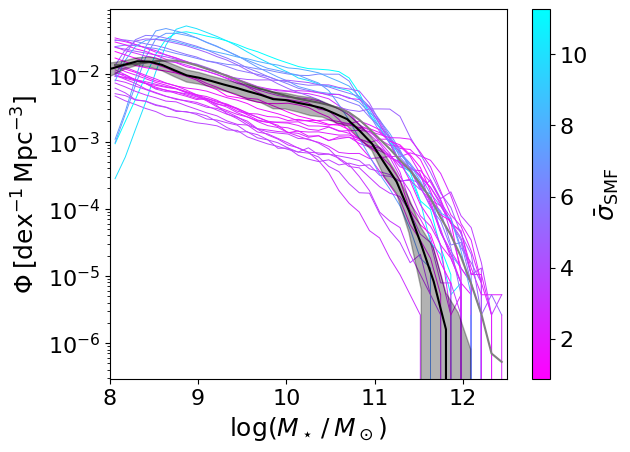

In [17]:
for i in range(n_sams):
    plt.plot(bins_avg, smf_arr[i], lw=0.7, color=colors[i])
ax = plt.gca()
sm = plt.cm.ScalarMappable(cmap=cmap, norm=locs_norm)
plt.colorbar(sm, ax=ax, label=r'$\bar{\sigma}_\text{SMF}$')

smf_mean = np.mean(smf_arr, axis=0)
smf_std = np.std(smf_arr, axis=0)
plt.plot(bins_avg, smf_mean, color='grey')
# plt.fill_between(bins_avg, 
#                  (smf_mean-smf_std), 
#                  (smf_mean+smf_std),
#                  color='magenta', alpha=0.3, lw=2,
#                  label='pSMF all')
    
plt.plot(ms, psmf_bgs_mean, color='black')
plt.fill_between(ms, 
                 psmf_bgs_mean-psmf_bgs_std, 
                 psmf_bgs_mean+psmf_bgs_std,
                 color='black', alpha=0.3,
                 zorder=10000,
                 label='BGS pSMF')
    
plt.yscale('log')
plt.xlabel(r'$\log(M_\star\,/\,M_\odot)$')
plt.ylabel(r'$\Phi \: [\mathrm{dex}^{-1}\, \mathrm{Mpc}^{-3}]$')
plt.xlim(8, 12.5)

## Set up bacco P(k) code

In [18]:
args_power = {'ngrid':ngrid,
                  'box':BoxSize,
                  'cosmology':cosmo_Quijote,
                  'interlacing':True,
                  'kmin':0.1,
                  'kmax':1.0,
                  'nbins':16,
                  'correct_grid':True,
                  'log_binning':False,
                  'deposit_method':'cic',
                  'compute_correlation':False,
                  'zspace':False,
                  'normalise_grid': True,
                  'compute_power2d':False}

In [19]:
import logging
logger = logging.getLogger("bacco.power")
# only log really bad events
logger.setLevel(logging.ERROR)

In [20]:
pks = []
for i in range(n_sams):
    fn_dat = fns_dat[i]
    with h5py.File(fn_dat, 'r') as f:
        x_arr, y_arr, z_arr = f['x_position'], f['y_position'], f['z_position']
        pos_arr = np.array([x_arr, y_arr, z_arr]).T
        pk = bacco.statistics.compute_powerspectrum(pos=pos_arr, **args_power)
        pks.append(pk)

2024-01-07 21:16:40,353 bacco.statistics : Computing the power spectrum with ngrid=256 and interlacing=True
2024-01-07 21:16:40,647 bacco.cosmo :    computed CAMB power spectrum at z=0.00 in 0.202 secs
2024-01-07 21:16:40,657 bacco.cosmo :    created Pk(z=0) tab from k 7.450454722857103e-05 to 100000.0 h/Mpc
2024-01-07 21:16:40,662 bacco.cosmo :    computed halofit at z=0.00 for 'cosmo_BOSS' in 0.002 secs
2024-01-07 21:16:40,664 bacco.statistics :  setting the grid 256 True
2024-01-07 21:16:40,664 bacco.statistics : Computing cic mesh with ngrid=256 and interlacing=True
2024-01-07 21:16:40,667 bacco.statistics : starting deposit 1
2024-01-07 21:16:40,720 bacco.statistics :  mesh done in 0.0552 s
2024-01-07 21:16:40,721 bacco.statistics :  Starting the power spectrum calculation
2024-01-07 21:16:40,848 bacco.statistics :  done compute.power
2024-01-07 21:16:40,850 bacco.statistics :  power done in 0.497 s
2024-01-07 21:16:40,869 bacco.statistics : Computing the power spectrum with ngrid

bacco.mesh : boxsize=149.009094 ngrid=256, nthreads=12, vel_factor=0.000000, interlacing=1, folds=1.000000, 2d=0
bacco.mesh : allocating 128.0 Mb
bacco.mesh : binning of 174733 particles (1 with mass)
bacco.mesh : Using mass = 1.000000
bacco.power : boxsize 149.009094; ngrid 256; nthreads 12; interlacing 1; deposit_method 1; log_binning 0; type 0; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 174733 (grid1) 174733 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.042772 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.046939 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000100 secs
bacco.power : Deallocating arrays
bacco.mesh : boxsize=149.009094 ngrid=256, nthreads=12, vel_factor=0.000000, interlacing=1, folds=1.000000, 2d=0
bacco.mesh : allocating 128.0 Mb
bacco.mesh : binning of 135120 particles (1 wit

2024-01-07 21:16:41,931 bacco.statistics : Computing the power spectrum with ngrid=256 and interlacing=True
2024-01-07 21:16:41,933 bacco.statistics :  setting the grid 256 True
2024-01-07 21:16:41,934 bacco.statistics : Computing cic mesh with ngrid=256 and interlacing=True
2024-01-07 21:16:41,935 bacco.statistics : starting deposit 1
2024-01-07 21:16:41,992 bacco.statistics :  mesh done in 0.0578 s
2024-01-07 21:16:41,993 bacco.statistics :  Starting the power spectrum calculation
2024-01-07 21:16:42,112 bacco.statistics :  done compute.power
2024-01-07 21:16:42,114 bacco.statistics :  power done in 0.182 s
2024-01-07 21:16:42,133 bacco.statistics : Computing the power spectrum with ngrid=256 and interlacing=True
2024-01-07 21:16:42,134 bacco.statistics :  setting the grid 256 True
2024-01-07 21:16:42,135 bacco.statistics : Computing cic mesh with ngrid=256 and interlacing=True
2024-01-07 21:16:42,136 bacco.statistics : starting deposit 1
2024-01-07 21:16:42,200 bacco.statistics :  m

actor=0.000000, interlacing=1, folds=1.000000, 2d=0
bacco.mesh : allocating 128.0 Mb
bacco.mesh : binning of 176420 particles (1 with mass)
bacco.mesh : Using mass = 1.000000
bacco.power : boxsize 149.009094; ngrid 256; nthreads 12; interlacing 1; deposit_method 1; log_binning 0; type 0; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 176420 (grid1) 176420 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.037670 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.043601 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000083 secs
bacco.power : Deallocating arrays
bacco.mesh : boxsize=149.009094 ngrid=256, nthreads=12, vel_factor=0.000000, interlacing=1, folds=1.000000, 2d=0
bacco.mesh : allocating 128.0 Mb
bacco.mesh : binning of 151754 particles (1 with mass)
bacco.mesh : Using mass = 1.000000
bacco.power : boxs

2024-01-07 21:16:43,025 bacco.statistics :  done compute.power
2024-01-07 21:16:43,026 bacco.statistics :  power done in 0.239 s
2024-01-07 21:16:43,054 bacco.statistics : Computing the power spectrum with ngrid=256 and interlacing=True
2024-01-07 21:16:43,056 bacco.statistics :  setting the grid 256 True
2024-01-07 21:16:43,056 bacco.statistics : Computing cic mesh with ngrid=256 and interlacing=True
2024-01-07 21:16:43,058 bacco.statistics : starting deposit 1
2024-01-07 21:16:43,123 bacco.statistics :  mesh done in 0.0663 s
2024-01-07 21:16:43,124 bacco.statistics :  Starting the power spectrum calculation
2024-01-07 21:16:43,267 bacco.statistics :  done compute.power
2024-01-07 21:16:43,268 bacco.statistics :  power done in 0.214 s
2024-01-07 21:16:43,291 bacco.statistics : Computing the power spectrum with ngrid=256 and interlacing=True
2024-01-07 21:16:43,293 bacco.statistics :  setting the grid 256 True
2024-01-07 21:16:43,293 bacco.statistics : Computing cic mesh with ngrid=256

h : allocating 128.0 Mb
bacco.mesh : binning of 154917 particles (1 with mass)
bacco.mesh : Using mass = 1.000000
bacco.power : boxsize 149.009094; ngrid 256; nthreads 12; interlacing 1; deposit_method 1; log_binning 0; type 0; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 154917 (grid1) 154917 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.041329 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.044283 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000088 secs
bacco.power : Deallocating arrays
bacco.mesh : boxsize=149.009094 ngrid=256, nthreads=12, vel_factor=0.000000, interlacing=1, folds=1.000000, 2d=0
bacco.mesh : allocating 128.0 Mb
bacco.mesh : binning of 166849 particles (1 with mass)
bacco.mesh : Using mass = 1.000000
bacco.power : boxsize 149.009094; ngrid 256; nthreads 12; interlacing 1; deposi

2024-01-07 21:16:44,379 bacco.statistics :  mesh done in 0.0734 s
2024-01-07 21:16:44,380 bacco.statistics :  Starting the power spectrum calculation
2024-01-07 21:16:44,529 bacco.statistics :  done compute.power
2024-01-07 21:16:44,535 bacco.statistics :  power done in 0.232 s
2024-01-07 21:16:44,565 bacco.statistics : Computing the power spectrum with ngrid=256 and interlacing=True
2024-01-07 21:16:44,567 bacco.statistics :  setting the grid 256 True
2024-01-07 21:16:44,567 bacco.statistics : Computing cic mesh with ngrid=256 and interlacing=True
2024-01-07 21:16:44,569 bacco.statistics : starting deposit 1
2024-01-07 21:16:44,642 bacco.statistics :  mesh done in 0.0743 s
2024-01-07 21:16:44,643 bacco.statistics :  Starting the power spectrum calculation
2024-01-07 21:16:44,793 bacco.statistics :  done compute.power
2024-01-07 21:16:44,794 bacco.statistics :  power done in 0.229 s
2024-01-07 21:16:44,819 bacco.statistics : Computing the power spectrum with ngrid=256 and interlacing=T

les (1 with mass)
bacco.mesh : Using mass = 1.000000
bacco.power : boxsize 149.009094; ngrid 256; nthreads 12; interlacing 1; deposit_method 1; log_binning 0; type 0; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 152059 (grid1) 152059 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.043485 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.045965 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000087 secs
bacco.power : Deallocating arrays
bacco.mesh : boxsize=149.009094 ngrid=256, nthreads=12, vel_factor=0.000000, interlacing=1, folds=1.000000, 2d=0
bacco.mesh : allocating 128.0 Mb
bacco.mesh : binning of 164702 particles (1 with mass)
bacco.mesh : Using mass = 1.000000
bacco.power : boxsize 149.009094; ngrid 256; nthreads 12; interlacing 1; deposit_method 1; log_binning 0; type 0; precision=single; correct_

2024-01-07 21:16:45,788 bacco.statistics :  done compute.power
2024-01-07 21:16:45,789 bacco.statistics :  power done in 0.21 s
2024-01-07 21:16:45,811 bacco.statistics : Computing the power spectrum with ngrid=256 and interlacing=True
2024-01-07 21:16:45,813 bacco.statistics :  setting the grid 256 True
2024-01-07 21:16:45,814 bacco.statistics : Computing cic mesh with ngrid=256 and interlacing=True
2024-01-07 21:16:45,815 bacco.statistics : starting deposit 1
2024-01-07 21:16:45,870 bacco.statistics :  mesh done in 0.0561 s
2024-01-07 21:16:45,871 bacco.statistics :  Starting the power spectrum calculation
2024-01-07 21:16:45,993 bacco.statistics :  done compute.power
2024-01-07 21:16:45,995 bacco.statistics :  power done in 0.184 s
2024-01-07 21:16:46,017 bacco.statistics : Computing the power spectrum with ngrid=256 and interlacing=True
2024-01-07 21:16:46,019 bacco.statistics :  setting the grid 256 True
2024-01-07 21:16:46,020 bacco.statistics : Computing cic mesh with ngrid=256 

wer : boxsize 149.009094; ngrid 256; nthreads 12; interlacing 1; deposit_method 1; log_binning 0; type 0; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 172757 (grid1) 172757 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.040891 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.046153 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000087 secs
bacco.power : Deallocating arrays
bacco.mesh : boxsize=149.009094 ngrid=256, nthreads=12, vel_factor=0.000000, interlacing=1, folds=1.000000, 2d=0
bacco.mesh : allocating 128.0 Mb
bacco.mesh : binning of 170257 particles (1 with mass)
bacco.mesh : Using mass = 1.000000
bacco.power : boxsize 149.009094; ngrid 256; nthreads 12; interlacing 1; deposit_method 1; log_binning 0; type 0; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 

2024-01-07 21:16:47,110 bacco.statistics :  done compute.power
2024-01-07 21:16:47,112 bacco.statistics :  power done in 0.236 s
2024-01-07 21:16:47,136 bacco.statistics : Computing the power spectrum with ngrid=256 and interlacing=True
2024-01-07 21:16:47,137 bacco.statistics :  setting the grid 256 True
2024-01-07 21:16:47,138 bacco.statistics : Computing cic mesh with ngrid=256 and interlacing=True
2024-01-07 21:16:47,139 bacco.statistics : starting deposit 1
2024-01-07 21:16:47,218 bacco.statistics :  mesh done in 0.0796 s
2024-01-07 21:16:47,219 bacco.statistics :  Starting the power spectrum calculation
2024-01-07 21:16:47,379 bacco.statistics :  done compute.power
2024-01-07 21:16:47,380 bacco.statistics :  power done in 0.244 s
2024-01-07 21:16:47,407 bacco.statistics : Computing the power spectrum with ngrid=256 and interlacing=True
2024-01-07 21:16:47,409 bacco.statistics :  setting the grid 256 True
2024-01-07 21:16:47,409 bacco.statistics : Computing cic mesh with ngrid=256

Text(0, 0.5, '$P(k)$')

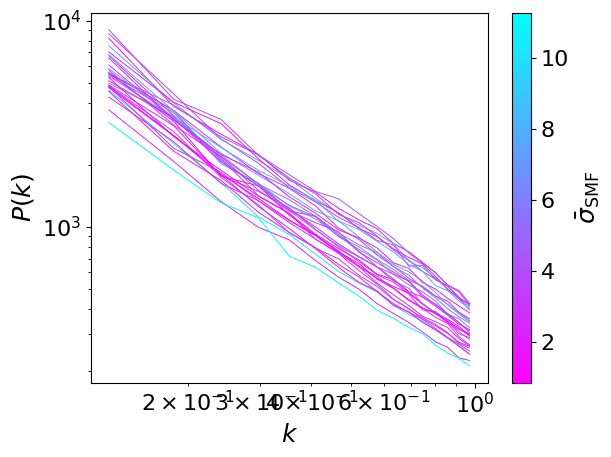

In [21]:
for i in range(n_sams):
    plt.plot(pks[i]['k'], pks[i]['pk'], lw=0.7, color=colors[i])
    
ax = plt.gca()
sm = plt.cm.ScalarMappable(cmap=cmap, norm=locs_norm)
plt.colorbar(sm, ax=ax, label=r'$\bar{\sigma}_\text{SMF}$')
    
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$k$')
plt.ylabel(r'$P(k)$')

In [22]:
k_sam_all = pks[0]['k'] # same for all 

## Load bacco emu

In [23]:
emulator = baccoemu.Lbias_expansion()

Loading l-bias lpt emulator...


/dipc/kstoreyf/.conda/envs/baccoenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 0.24.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/dipc/kstoreyf/.conda/envs/baccoenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 0.24.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/dipc/kstoreyf/.conda/envs/baccoenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 0.24.2 when u

/dipc/kstoreyf/.conda/envs/baccoenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 0.24.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/dipc/kstoreyf/.conda/envs/baccoenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 0.24.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/dipc/kstoreyf/.conda/envs/baccoenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 0.24.2 when u

L-bias lpt emulator loaded in memory.
Loading smeared bao emulator...
Smeared bao emulator loaded in memory.
Loading non-linear l-bias emulator...


/dipc/kstoreyf/.conda/envs/baccoenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 1.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/dipc/kstoreyf/.conda/envs/baccoenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/dipc/kstoreyf/.conda/envs/baccoenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 0.23.2 w

Nonlinear l-bias emulator loaded in memory.
Loading sigma8 emulator...
Sigma8 emulator loaded in memory.
Loading no-wiggles emulator...
No-wiggles emulator loaded in memory.


/dipc/kstoreyf/.conda/envs/baccoenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.0.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [24]:
#k = np.logspace(-1.9, np.log10(emulator.emulator['nonlinear']['k'].max()), num=100)

In [34]:
# should this match camels??
cosmo_params = {
    'omega_cold'    :  Om,
    'sigma8_cold'   :  sigma8, # if A_s is not specified
    'omega_baryon'  :  Ob,
    'ns'            :  ns,
    'hubble'        :  hubble,
    'neutrino_mass' :  0.0,
    'w0'            : -1.0,
    'wa'            :  0.0,
    'expfactor'     :  1
}

In [26]:
#k, pnn = emulator.get_nonlinear_pnn(k=k, **params)

### Fit bias params

In [27]:
def ln_like(free_params, k_data, pk_data, variance,
            nbar, emulator, cosmo_params):
    bias_params = free_params[:4]
    A_sn = free_params[-1]
    _, pk_gg, _ = emulator.get_galaxy_real_pk(bias=bias_params, k=k_data,
                                             **cosmo_params)
    pk_model = pk_gg + A_sn/nbar
    delta_y = pk_data - pk_gg
    lnlk = 0.5 * np.sum((delta_y/variance)**2)
    #lnlk = 0.5 * delta_y.T @ C_inv @ delta_y
    return lnlk

In [28]:
i_bins = k_sam_all < 0.75
k_sam = k_sam_all[i_bins]
C_inv = np.diag(np.ones(len(k_sam))/len(k_sam))

In [29]:
bias_param_names = ['b1', 'b2', 'bs2', 'bl']
bias_param_labels = {'b1': r'$b_1$', 
                     'b2': r'$b_2$', 
                     'bs2': r'$b_{s^2}$', 
                     'bl': r'$b_{\nabla^2 \delta}$',
                    }
free_param_names = bias_param_names + ['Asn']
bounds_dict = {'b1': [-5, 20],
                'b2': [-5, 10],
                'bs2': [-10, 20],
                'bl': [-20, 30],
                'Asn': [0, 2],
                }
bounds = [bounds_dict[param_name] for param_name in free_param_names]

In [30]:
n_fit = 1

In [40]:
free_params_0 = [0.5, 0.5, 1.0, -1.0, 1.0]
res_arr = []
var_arr = []
for i in range(n_fit):
    print(f"Fitting SAM {i}")
    pk_sam = pks[i]['pk'][i_bins]
    
    err_poisson = pk['shotnoise'][i_bins]
    err_1p = 0.01*pk_sam
    variance = err_poisson**2 + err_1p**2
    var_arr.append(variance)

    res = scipy.optimize.minimize(ln_like, free_params_0, bounds=bounds, 
                                  args=(k_sam, pk_sam, variance, nbar_arr[i], emulator, cosmo_params))
    res_arr.append(res)

Fitting SAM 0


In [42]:
print(np.sum([res['success'] for res in res_arr]))

1


Text(0.5, 0, '$k$')

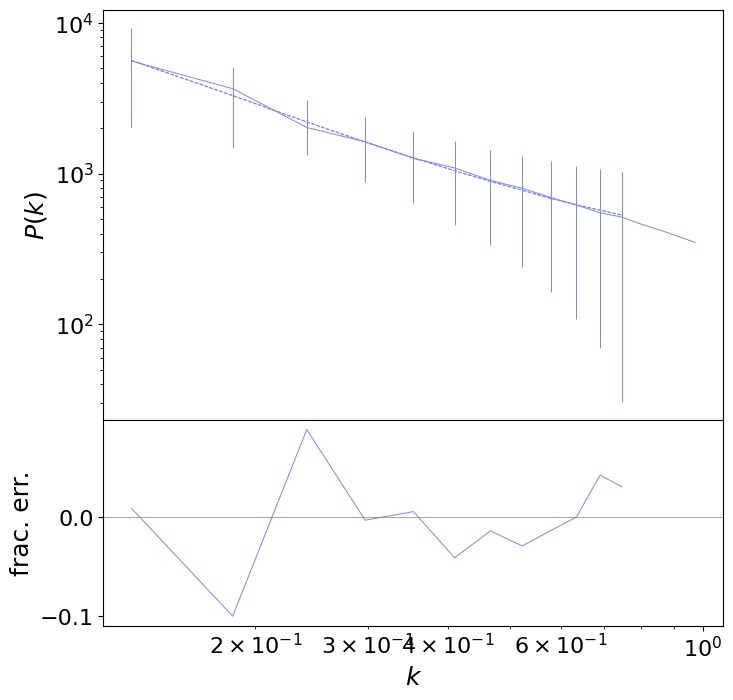

In [41]:
nrows, ncols = 2, 1
fig, axarr = plt.subplots(nrows, ncols, figsize=(8,8), sharex=True, height_ratios=[2,1])
plt.subplots_adjust(hspace=0)

for i in range(n_fit):
    axarr[0].plot(pks[i]['k'], pks[i]['pk'], lw=0.7, color=colors[i])
    bias_params = res_arr[i]['x'][:4]
    _, pk_emu, _ = emulator.get_galaxy_real_pk(bias=bias_params, k=k_sam, **params)
    axarr[0].plot(k_sam, pk_emu, lw=0.7, ls='--', color=colors[i])
    axarr[0].errorbar(k_sam, pk_emu, yerr=var_arr[i], lw=0.7, ls='--', color=colors[i])
    axarr[0].set_ylabel(r'$P(k)$')
    
    axarr[1].plot(k_sam, (pk_emu-pks[i]['pk'][i_bins])/pks[i]['pk'][i_bins], lw=0.7, color=colors[i])
    axarr[1].set_ylabel('frac. err.')
    axarr[1].axhline(0, color='grey', lw=0.5)

plt.xscale('log')
axarr[0].set_yscale('log')
plt.xlabel(r'$k$')

## Plot bias params

In [ ]:
nrows, ncols = 3, 1
fig, axarr = plt.subplots(nrows, ncols, figsize=(5, 3*nrows), sharex=True)
plt.subplots_adjust(hspace=0)

for i in range(n_fit):
    bias_params = res_arr[i]['x']
    for bb in range(1,len(bias_param_names)):
        axarr[bb-1].plot(bias_params[0], bias_params[bb], marker='o', markersize=6, color=colors[i])
        axarr[bb-1].set_ylabel(bias_param_labels[bias_param_names[bb]])

plt.xlabel(bias_param_labels[bias_param_names[0]])